In [1]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
sklearn 0.20.1
pandas 0.23.4
matplotlib 3.0.2


**3장 – 분류**

_이 노트북은 3장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

In [3]:
#서버 문제로 데이터 로드 실패 > 생략
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


ConnectionAbortedError: [WinError 10053] 현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다

In [4]:
#mnist 데이터 로드
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)

with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

In [5]:
mnist #data : (70000, 784)개의 픽셀 데이터
      #target : 레이블
      #descr : 데이터셋 설명

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original'}

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
28*28 #총 784개의 픽셀, 각 픽셀은 흰색/검은색

784

`fetch_mldata`는 0.22 버전에서 삭제될 예정입니다. 0.20 버전에서 관련된 경고를 피하기 위해 대신 `fetch_openml` 함수를 사용하는 것이 좋습니다.

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


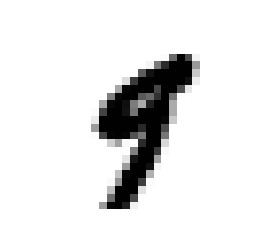

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000] #임의 데이터 확인
some_digit_image = some_digit.reshape(28, 28) #기존 픽셀 모양대로 변경
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
#save_fig("some_digit_plot") #파일로 저장
plt.show()

In [11]:
y[36000] #실제 레이블 확인

9

In [12]:
#이미지 생성 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

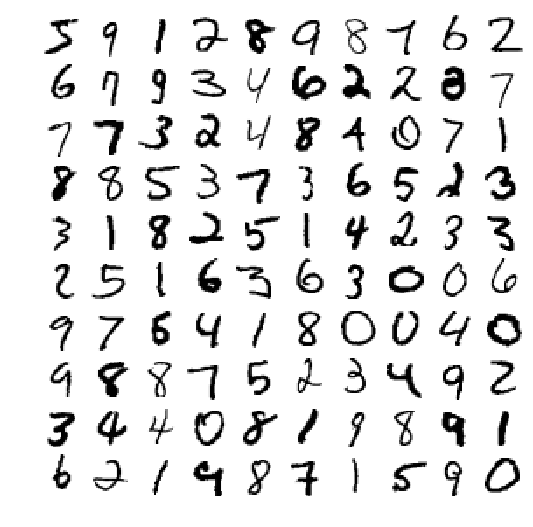

In [14]:
#더 많은 임의의 데이터 확인
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [15]:
#train, test 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

In [16]:
import numpy as np

#교차 검증을 위한 데이터 섞기
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 이진 분류기

In [17]:
#이진 분류기 레이블 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [18]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5) #모델 학습

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
sgd_clf.predict([some_digit]) #예측 결과

array([False])

In [20]:
#'5로 분류' 분류기의 정확도
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

array([0.9605 , 0.95595, 0.95375])

In [21]:
#위의 cross_val_score() 함수와 같은 기능
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.95595


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.95375


In [22]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
#'5 아님으로 분류' 분류기의 정확도
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#데이터의 불균형이 심할 때는 좋은 분류기가 될 수 없음.

array([0.909  , 0.90745, 0.9125 ])

In [24]:
#교차 검증
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

In [25]:
y_train_pred #추후 다시

array([False, False, False, ..., False, False, False])

In [26]:
#오차 행렬
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) #왼쪽 위부터 TN FP FN TP

array([[52972,  1607],
       [  989,  4432]], dtype=int64)

In [27]:
y_train_perfect_predictions = y_train_5

In [28]:
#완벽한 분류기에서의 TN TP
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [29]:
#정밀도 : 양성이라고 판단한 것 중 맞은 것, TP/(TP + FP)
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7338963404537175

In [30]:
4344 / (4344 + 1307) #위와 같은 결과

0.7687135020350381

In [31]:
#재현율 : 실제 양성 중 맞다고 판단한 것, TP/(TP + FN)
recall_score(y_train_5, y_train_pred)

0.8175613355469471

In [32]:
4344 / (4344 + 1077) #위와 같은 결과

0.801328168234643

In [33]:
#F1 점수 계산 : 정밀도와 재현율의 조화평균
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7734729493891798

In [34]:
4344 / (4344 + (1077 + 1307)/2) #위와 같은 결과

0.7846820809248555

In [36]:
#임의 데이터의 결정 점수
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-176288.21703149])

In [37]:
threshold = 0 #임곗값
y_some_digit_pred = (y_scores > threshold)

In [38]:
y_some_digit_pred

array([False])

In [39]:
#임곗값 증가에 따른 재현율 감소
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [40]:
#모든 데이터의 결정 점수
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

노트: 만약 사이킷런 0.19.0 버전을 사용하고 있다면 `method="decision_function"` 옵션으로 `cross_val_predict()` 함수를 사용할 때 이진 분류에서 1차원 배열이 아니고 2차원 배열을 반환하는 [버그](https://github.com/scikit-learn/scikit-learn/issues/9589)가 있습니다. 사이킷런 0.19.1로 업그레이드하거나 다음 셀에서 y_scores\[:, 1\] 처럼 두 번째 열만 사용해야 합니다.

In [41]:
y_scores.shape

(60000,)

In [42]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
# if y_scores.ndim == 2:
#     y_scores = y_scores[:, 1]

In [43]:
#정밀도, 재현율, 임곗값 계산
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


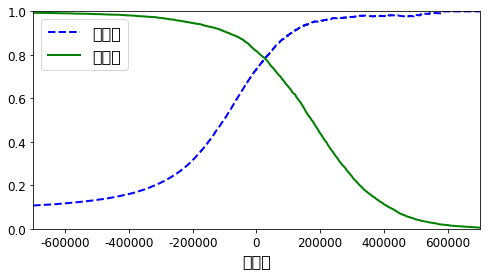

In [44]:
#정밀도, 재현율 그래프 생성 > 트레이드 오프 > 적절한 임곗값 찾기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [45]:
(y_train_pred == (y_scores > 0)).all() #추후

True

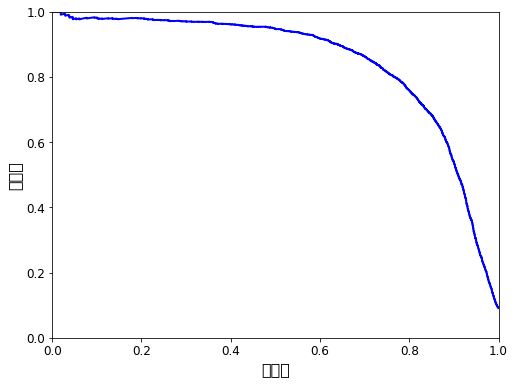

In [46]:
#재현율에 대한 정밀도 곡선 > 80%에서 급하강
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

In [47]:
#정밀도 90%를 위한 임곗값
y_train_pred_90 = (y_scores > 70000)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.855198572066042

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.7070651171370596

# ROC 곡선

In [50]:
#FPR, TPR, 임곗값 계산
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

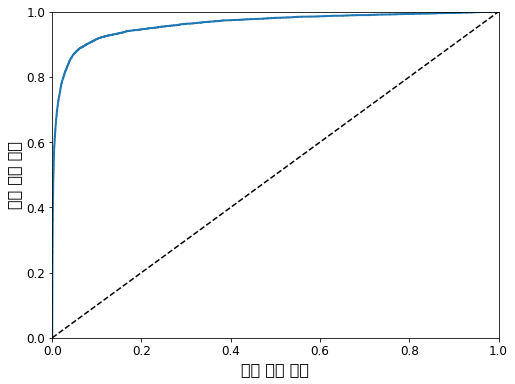

In [51]:
#ROC 곡선 생성(민감도에 대한 특이도 그래프)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율', fontsize=16)
    plt.ylabel('진짜 양성 비율', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

In [52]:
#AUC 계산, 1이 가장 좋음
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9614189997126434

랜덤 포레스트 `n_estimator` 매개변수의 기본값이 0.22 버전에서 10에서 100으로 변경될 예정입니다. 경고를 피하기 위해서 `n_estimator=10`으로 지정합니다.

In [53]:
#랜덤포레스트 분류기 생성
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [54]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

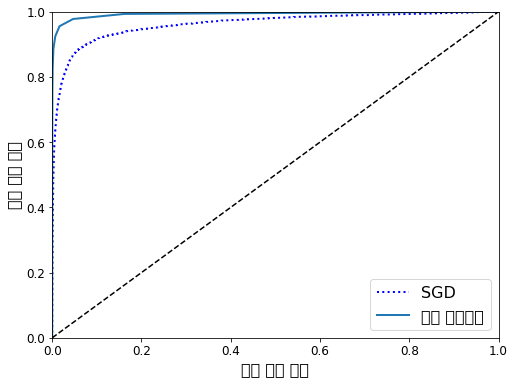

In [56]:
#기존 SGD 분류기와 랜덤포레스트 분류기의 ROC 커브 비교
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [57]:
#AUC 계산
roc_auc_score(y_train_5, y_scores_forest)

0.9928250745111685

In [58]:
#랜덤 포레스트의 정밀도
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9870386643233744

In [59]:
#랜덤 포레스트의 재현율
recall_score(y_train_5, y_train_pred_forest)

0.8288138719793396

# 다중 분류

In [60]:
#일대다 전략 : 결정점수가 가장 높은 클래스 선택
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


array([4])

In [61]:
#각 클래스에 대한 결정점수
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-736165.13534356, -391182.59305387, -752094.90919363,
        -199593.6564959 ,  -33428.88555026, -176288.21703149,
        -856742.40238951, -145757.71304016, -253587.97052021,
        -249064.39096412]])

In [62]:
np.argmax(some_digit_scores) #결정점수가 가장 높은 클래스

4

In [63]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [64]:
sgd_clf.classes_[5]

5

In [65]:
#일대일 전략 : 모든 클래스 조합으로 이진 분류기 생성
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

array([9])

In [66]:
len(ovo_clf.estimators_) #10개 클래스의 이진 분류기 조합, N(N-1)/2

45

In [67]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit]) #확률이 가장 높은 클래스

array([9])

In [68]:
forest_clf.predict_proba([some_digit]) #조합 분류기를 통해 부여된 클래스별 확률

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [69]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") #분류기의 정확도 평가

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

array([0.81908618, 0.86379319, 0.84492674])

In [70]:
#스케일 조정을 통한 정확도 향상
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

array([0.91131774, 0.90884544, 0.90883633])

In [71]:
#오차 행렬 생성
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

array([[5730,    2,   22,    9,   11,   52,   47,    8,   39,    3],
       [   1, 6459,   54,   29,    6,   43,    6,   11,  123,   10],
       [  53,   34, 5371,   90,   80,   23,   79,   57,  157,   14],
       [  48,   37,  147, 5315,    3,  248,   36,   58,  143,   96],
       [  20,   25,   45,   10, 5338,   10,   49,   36,   87,  222],
       [  72,   40,   38,  170,   72, 4616,  108,   28,  186,   91],
       [  35,   24,   56,    1,   39,   86, 5622,    6,   49,    0],
       [  22,   20,   73,   28,   48,   12,    4, 5832,   18,  208],
       [  53,  146,   84,  152,   14,  147,   55,   27, 5037,  136],
       [  44,   33,   29,   89,  164,   39,    3,  211,   77, 5260]],
      dtype=int64)

In [72]:
#생략해도 무방
def plot_confusion_matrix(matrix):
    """컬러 오차 행렬을 원할 경우"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

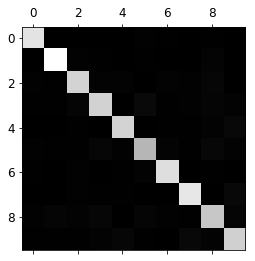

In [73]:
#오차 행렬 시각화
plt.matshow(conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [74]:
#클래스별 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

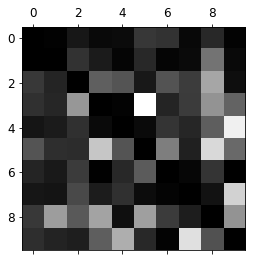

In [75]:
#주대각선을 0으로 만든 후 시각화
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()
#8, 9 부분 밝음 : 많은 데이터가 8, 9로 잘못 분류됨
#1 부분 어두움 : 1로 정확하게 잘 분류됨

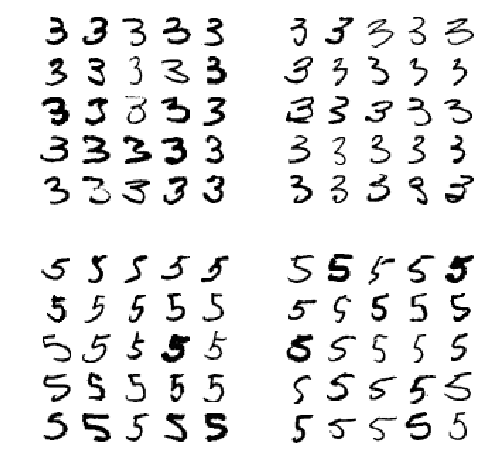

In [76]:
#3, 5 샘플 보기
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()
#왼쪽 위부터 3>3 3>5 5>3 5>5

# 다중 레이블 분류

In [77]:
#임의의 데이터로 두개 타겟 레이블(>7, 홀수) 생성
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [78]:
knn_clf.predict([some_digit]) #예측 결과

array([[ True,  True]])

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

In [79]:
#다중 레이블 분류기 평가 : 각 레이블의 F1 점수 구한 후 평균

#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
#f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 다중 출력 분류

In [80]:
#임의의 테스트 데이터에 노이즈 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

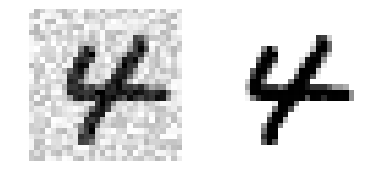

In [81]:
#임의의 테스트 데이터 보기
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

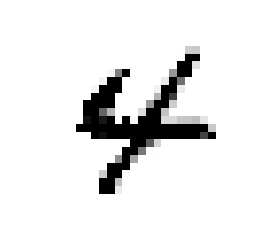

In [82]:
#픽셀당 한 레이블을 가지도록 모델 학습
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")

# 추가 내용

## 더미 (즉, 랜덤) 분류기

In [83]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

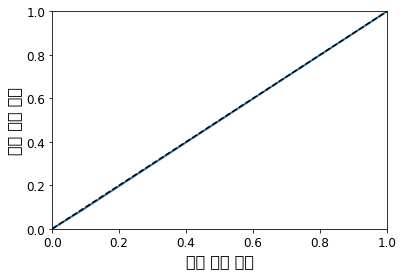

In [84]:
#랜덤 분류기의 ROC 커브, AUC=0.5
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN 분류기

In [85]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [86]:
#경고 : 오래 걸림
#y_knn_pred = knn_clf.predict(X_test)

In [87]:
#KNN 분류기의 정확도
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

NameError: name 'y_knn_pred' is not defined

In [ ]:
#???
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [ ]:
#KNN 확장시켜 사용
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [ ]:
#경고 : 오래 걸림
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
#경고 : 오래 걸림
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
#모호한 데이터 분류에 사용
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

# 연습문제 해답

## 1. 97% 정확도의 MNIST 분류기

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
#97% 정확도를 위한 KNN 분류기
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## 2. 데이터 증식

In [ ]:
#데이터 증식(이동)을 통해 분류기 정확도를 향상시킬 수 있음
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

간단한 데이터 증식으로 0.5%의 정확도가 향상되었습니다. :)

## 3. 타이타닉 데이터셋에 도전

승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표입니다.

먼저 [캐글](https://www.kaggle.com)에 로그인 하고 [타이타닉 챌린지](https://www.kaggle.com/c/titanic)에서 `train.csv`와 `test.csv`를 다운로드합니다. 두 파일을 `datasets/titanic` 디렉토리에 저장하세요.

그다음 데이터를 적재합니다:

In [88]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [89]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [90]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있습니다. 그러나 테스트 데이터는 레이블을 가지고 있지 않습니다: 훈련 데이터를 이용하여 가능한 최고의 모델을 만들고 테스트 데이터에 대한 예측을 캐글(Kaggle)에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

훈련 세트에서 맨 위 몇 개의 열을 살펴 보겠습니다:

In [91]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


속성은 다음과 같은 의미를 가집니다:
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

누락된 데이터가 얼마나 되는지 알아보겠습니다:

In [92]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


괜찮네요. **Age**, **Cabin**, **Embarked** 속성의 일부가 null입니다(891개의 non-null 보다 작습니다). 특히 **Cabin**은 77%가 null입니다. 일단 **Cabin**은 무시하고 나머지를 활용하겠습니다. **Age**는 19%가 null이므로 이를 어떻게 처리할지 결정해야 합니다. null을 중간 나이로 바꾸는 것이 괜찮아 보입니다.

**Name**과 **Ticket** 속성도 값을 가지고 있지만 머신러닝 모델이 사용할 수 있는 숫자로 변환하는 것이 조금 까다롭습니다. 그래서 지금은 이 두 속성을 무시하겠습니다.

통계치를 살펴 보겠습니다:

In [93]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 이크, 38%만 **Survived**입니다. :( 거의 40%에 가까우므로 정확도를 사용해 모델을 평가해도 괜찮을 것 같습니다.
* 평균 **Fare**는 32.20 파운드라 그렇게 비싸보이지는 않습니다(아마 요금을 많이 반환해 주었기 때문일 것입니다)
* 평균 **Age**는 30보다 작습니다.

타깃이 0과 1로 이루어졌는지 확인합니다:

In [94]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

범주형 특성들을 확인해 보겠습니다:

In [95]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [96]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [97]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Embarked** 특성은 승객이 탑승한 곳을 알려 줍니다: C=Cherbourg, Q=Queenstown, S=Southampton.

`CategoricalEncoder` 클래스는 범주형 특성을 원-핫 벡터로 변환시켜 줍니다. 이 클래스는 사이킷런 0.20에 포함될 예정이지만 지금은 아래 코드를 사용합니다([#9151](https://github.com/scikit-learn/scikit-learn/pull/9151) 풀 리퀘스트에서 복사했습니다).

In [98]:
# PR #9151에서 가져온 CategoricalEncoder 클래스의 정의.
# 이 클래스는 사이킷런 0.20에 포함될 예정입니다.
# 이 셀을 실행하거나 복사해서 사용하세요. 이 코드를 모두 이해할 필요는 없습니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

이제 전처리 파이프라인을 만듭니다. `DataFrame`으로부터 특정 속성만 선택하기 위해 이전 장에서 만든 `DataframeSelector`를 재사용하겠습니다:

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin

# 사이킷런이 DataFrame을 바로 사용하지 못하므로
# 수치형이나 범주형 컬럼을 선택하는 클래스를 만듭니다.
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

숫자 특성을 위한 파이프라인을 만듭니다(`Imputer` 클래스는 0.22 버전에서 삭제될 예정입니다. 0.20 버전에서 추가된 `SimpleImputer`를 사용합니다):

In [100]:
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [101]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로된 범주형 열을 위해 별도의 Imputer 클래스가 필요합니다(일반 `Imputer` 클래스는 이를 처리하지 못합니다):

In [102]:
# stackoverflow.com/questions/25239958 에서 착안했습니다
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

이제 범주형 특성을 위한 파이프라인을 만듭니다:

In [103]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

### future_encoders.py를 사용한 방법 ==========================

주의: 번역서는 `CategoricalEncoder`를 사용하여 각 범주형 값을 원-핫 벡터로 변경합니다. `OneHotEncoder`를 사용하는 것이 더 낫습니다. 지금은 정수형 범주 입력만 다룰 수 있지만 사이킷런 0.20에서는 문자열 범주 입력도 다룰 수 있을 것입니다(PR #10521). 지금은 `future_encoders.py` 파일에서 임포트하지만 사이킷런 0.20 버전이 릴리스되면 `sklearn.preprocessing`에서 바로 임포팅할 수 있습니다.

0.20에 추가된 `OneHotEncoder`를 사용하도록 코드를 변경합니다.

In [104]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

0.20 버전에 추가된 `SimpleImputer` 클래스에는 `most_frequent` 옵션을 사용할 수 있습니다:

In [105]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

### ====================================================

In [106]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

마지막으로 숫자와 범주형 파이프라인을 연결합니다:

In [107]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

사이킷런 0.20 버전에 추가된 `ColumnTransformer`를 사용하면 더 간단히 전처리 파이프라인을 구성할 수 있습니다.

In [108]:
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, ["Age", "SibSp", "Parch", "Fare"]),
        ("cat_pipeline", cat_pipeline, ["Pclass", "Sex", "Embarked"]),
    ])

좋습니다! 이제 원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었습니다.

In [109]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

레이블을 가져옵니다:

In [110]:
y_train = train_data["Survived"]

이제 분류기를 훈련시킬 차례입니다. 먼저 `SVC`를 사용해 보겠습니다:

In [111]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

모델이 잘 훈련된 것 같습니다. 이를 사용해서 테스트 세트에 대한 예측을 만듭니다:

In [112]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

이 예측 결과를 (캐글에서 기대하는 형태인) CSV 파일로 만들어 업로드하고 평가를 받아볼 수 있습니다. 하지만 그냥 좋을거라 기대하는 것보다 교차 검증으로 모델이 얼마나 좋은지 평가하는 것이 좋습니다.

In [113]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

정확도가 73% 이상입니다. 확실히 무작위로 선택한 것보다는 좋습니다. 하지만 아주 높은 점수는 아닙니다. 캐글에서 타이타닉 경연 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)를 보면 상위 10%내에 들려면 80% 이상의 정확도를 내야합니다. 어떤 사람들은 100%를 달성했습니다. 하지만 타이타닉의 [희생자 목록](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾을 수 있으므로 머신러닝을 사용하지 않고도 이런 정확도를 달성할 수 있습니다! ;-) 우리는 80% 정도의 정확도를 내는 모델을 만들어 보겠습니다.

`RandomForestClassifier`를 적용해 보겠습니다:

In [114]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8115690614005221

훨씬 좋네요!

10 폴드 교차 검증에 대한 평균 정확도를 보는 대신 모델에서 얻은 10개의 점수를 1사분위, 3사분위를 명료하게 표현해주는 상자 수염 그림(box-and-whisker) 그래프를 만들어 보겠습니다(이 방식을 제안해 준 Nevin Yilmaz에게 감사합니다). `boxplot()` 함수는 이상치(플라이어(flier)라고 부릅니다)를 감지하고 수염 부분에 이를 포함시키지 않습니다. 1사분위가 $Q_1$이고 3사분위가 $Q_3$이라면 사분위수 범위는 $IQR = Q_3 - Q_1$가 됩니다(이 값이 박스의 높이가 됩니다). $Q_1 - 1.5 \times IQR$ 보다 낮거나 $Q3 + 1.5 \times IQR$ 보다 높은 점수는 이상치로 간주됩니다.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


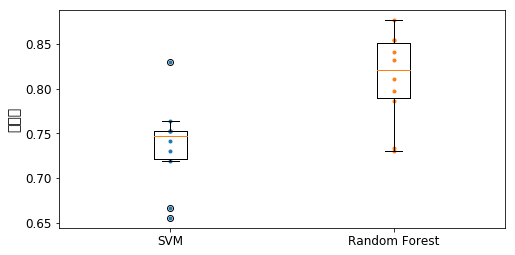

In [115]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("정확도", fontsize=14)
plt.show()

이 결과를 더 향상시키려면:
* 교차 검증과 그리드 탐색을 사용하여 더 많은 모델을 비교하고 하이퍼파라미터를 튜닝하세요.
* 특성 공학을 더 시도해 보세요, 예를 들면:
  * **SibSp**와 **Parch**을 이 두 특성의 합으로 바꿉니다.
  * **Survived** 특성과 관련된 이름을 구별해 보세요(가령, 이름에 "Countess"가 있는 경우 생존할 가능성이 높습니다).
* 수치 특성을 범주형 특성으로 바꾸어 보세요: 예를 들어, 나이대가 다른 경우 다른 생존 비율을 가질 수 있습니다(아래 참조). 그러므로 나이 구간을 범주로 만들어 나이 대신 사용하는 것이 도움이 될 수 있스니다. 비슷하게 생존자의 30%가 혼자 여행하는 사람이기 때문에 이들을 위한 특별한 범주를 만드는 것이 도움이 될 수 있습니다(아래 참조).

In [116]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [117]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. 스팸 필터

먼저 데이터를 다운받습니다:

In [118]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [119]:
fetch_spam_data()

다음, 모든 이메일을 읽어 들입니다:

In [ ]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [ ]:
len(ham_filenames)

In [ ]:
len(spam_filenames)

파이썬의 `email` 모듈을 사용해 이메일을 파싱합니다(헤더, 인코딩 등을 처리합니다):

In [ ]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

데이터가 어떻게 구성되어 있는지 감을 잡기 위해 햄 메일과 스팸 메일을 하나씩 보겠습니다:

In [ ]:
print(ham_emails[1].get_content().strip())

In [ ]:
print(spam_emails[6].get_content().strip())

어떤 이메일은 이미지나 첨부 파일을 가진 멀티파트(multipart)입니다(메일에 포함되어 있을수 있습니다). 어떤 파일들이 있는지 살펴 보겠습니다:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

In [ ]:
structures_counter(spam_emails).most_common()

햄 메일은 평범한 텍스트가 많고 스팸은 HTML일 경우가 많습니다. 적은 수의 햄 이메일이 PGP로 서명되어 있지만 스팸 메일에는 없습니다. 요약하면 이메일 구조는 유용한 정보입니다.

이제 이메일 헤더를 살펴보겠습니다:

In [ ]:
for header, value in spam_emails[0].items():
    print(header,":",value)

보낸사람의 이메일 주소와 같이 헤더에는 유용한 정보가 많이 있지만 여기서는 `Subject` 헤더만 다뤄 보겠습니다:

In [ ]:
spam_emails[0]["Subject"]

좋습니다. 데이터에를 더 살펴보기 전에 훈련 세트와 테스트 세트로 나누도록 하겠습니다:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

이제 전처리 함수를 작성하겠습니다. 먼저 HTML을 일반 텍스트로 변환하는 함수가 필요합니다. 이 작업에는 당연히 [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) 라이브러리를 사용하는게 좋지만 의존성을 줄이기 위해서 정규식을 사용하여 대강 만들어 보겠습니다([un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)의 위험에도 불구하고). 다음 함수는 `<head>` 섹션을 삭제하고 모든 `<a>` 태그를 HYPERLINK 문자로 바꿉니다. 그런 다음 모든 HTML 태그를 제거하고 텍스트만 남깁니다. 보기 편하게 여러개의 개행 문자를 하나로 만들고 (`&gt;`나 `&nbsp;` 같은) html 엔티티를 복원합니다:

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

잘 작동하는지 확인해 보겠습니다. 다음은 HTML 스팸입니다:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

변환된 텍스트입니다:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

아주 좋습니다! 이제 포맷에 상관없이 이메일을 입력으로 받아서 일반 텍스트를 출력하는 함수를 만들겠습니다:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")

어간 추출을 해보죠! 이 작업을 하려면 자연어 처리 툴킷([NLTK](http://www.nltk.org/))을 설치해야 합니다. 다음 명령으로 간단히 설치할 수 있습니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install nltk`

In [ ]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

인터넷 주소는 "URL" 문자로 바꾸겠습니다. [정규식](https://mathiasbynens.be/demo/url-regex)을 하드 코딩할 수도 있지만 [urlextract](https://github.com/lipoja/URLExtract) 라이브러리를 사용하겠습니다. 다음 명령으로 설치합니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install urlextract`

In [ ]:
try:
    import urlextract # 루트 도메인 이름을 다운로드하기 위해 인터넷 연결이 필요할지 모릅니다
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

이들을 모두 하나의 변환기로 연결하여 이메일을 단어 카운트로 바꿀 것입니다. 파이썬의 `split()` 메서드를 사용하면 구둣점과 단어 경계를 기준으로 문장을 단어로 바꿉니다. 이 방법이 많은 언어에 통하지만 전부는 아닙니다. 예를 들어 중국어와 일본어는 일반적으로 단어 사이에 공백을 두지 않습니다. 베트남어는 음절 사이에 공백을 두기도 합니다. 여기서는 데이터셋이 (거의) 영어로 되어 있기 때문에 문제없습니다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

이 변환기를 몇 개의 이메일에 적용해 보겠습니다:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

제대로 작동하는 것 같네요!

이제 단어 카운트를 벡터로 변환해야 합니다. 이를 위해서 또 다른 변환기를 만들겠습니다. 이 변환기는 (자주 나타나는 단어 순으로 정렬된) 어휘 목록을 구축하는 `fit()` 메서드와 어휘 목록을 사용해 단어를 벡터로 바꾸는 `transform()` 메서드를 가집니다. 출력은 희소 행렬이 됩니다.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

In [ ]:
X_few_vectors.toarray()

이 행렬은 무엇을 의미하나요? 세 번째 행의 첫 번째 열의 65는 세 번째 이메일이 어휘 목록에 없는 단어를 65개 가지고 있다는 뜻입니다. 그 다음의 0은 어휘 목록에 있는 첫 번째 단어가 한 번도 등장하지 않는다는 뜻이고 그 다음의 1은 한 번 나타난다는 뜻입니다. 이 단어들이 무엇인지 확인하려면 어휘 목록을 보면 됩니다. 첫 번째 단어는 "the"이고 두 번째 단어는 "of"입니다.

In [ ]:
vocab_transformer.vocabulary_

이제 스팸 분류기를 훈련시킬 준비를 마쳤습니다! 전체 데이터셋을 변환시켜보죠:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver='liblinear', random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

98.7%가 넘네요. 첫 번째 시도치고 나쁘지 않습니다! :) 그러나 이 데이터셋은 비교적 쉬운 문제입니다. 더 어려운 데이터셋에 적용해 보면 결과가 그리 높지 않을 것입니다. 여러개의 모델을 시도해 보고 제일 좋은 것을 골라 교차 검증으로 세밀하게 튜닝해 보세요.

하지만 전체 내용을 파악했으므로 여기서 멈추겠습니다. 테스트 세트에서 정밀도/재현율을 출력해 보겠습니다:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver='liblinear', random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))